In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

# Recurrent Neural Network
RNN sono una classe di reti neuronali applicabili a sequenza o serie temporali di lunghezza arbitraria.

Le reti feedforward o sequenziali viste sinora seguono un flusso la cui direzione procede dai livelli di input fino a quelli di output in maniera lineare.  Una RNN e' simile a questo tipo di reti tranne che presenta un **collegamento all'indietro**, come mostrato nella seguente figura che riporta la piu' semplice RNN.

![](rnn_simple.png)

Ad ogni step $t$ , la rete riceve  in input il segnale $\mathbf{x}_t$ e l'output $\mathbf{y}_{t-1}$ - l'output al passo precedente. 

Una rappresentazione equivalente alla precedente e' data dallo _srotolamento_ - **unfolding** della rete, come mostrato in figura:

![](unfolding.png)

in cui viene creato un layer di unita' ricorrenti o ricorsive.

In questa architettura ogni unita' riceve  due insiemi distinti di input:
- gli input dal livello di input
- le attivazioni dallo stesso livello generate al passo $t-1$

Ad ogni passo $t$ le unita' del livello hidden ricevono in input $\mathbf{x}_t$ e $\mathbf{h}_{t-1}$, cioe' i valori precedenti del livello hidden.

![](unfolding_2.png)

Ogni collegamento riportato in figura ha una matrice dei pesi associata che non dipendono dal tempo $t$. Le matrici dei pesi sono:
- $\mathbf{W}_{xh}$: la matrice dei pesi tra input $\mathbf{x}_t$ e $\mathbf{h}$
- $\mathbf{W}_{hh}$: la matrice associata al collegamento ricorrente
- $\mathbf{W}_{hy}$: la matrice tra il livello $\mathbf{h}$ e il livello di output $\mathbf{y}$

Il calcolo dell'attivazione e' simili alle reti sequenziali:

$$\mathbf{z}_h^t = \mathbf{W}_{hx}\mathbf{x}_t + \mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h$$

da cui

$$\mathbf{h}_t = \sigma_h(\mathbf{z}_h^t)=\sigma(\mathbf{W}_{hx}\mathbf{x}_t + \mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h) $$

riscrivibile come 

$$\mathbf{h}_t = \sigma_h([\mathbf{W}_{xh};\mathbf{W}_{hh}][\mathbf{x}_t^T;\mathbf{h}_{t-1}^T]^T + \mathbf{b}_h)$$

<br>

![](comp_schema.png)

Dal momento che l'output di un'unita' al tempo $t$ e' funzione dell'input dei passi precedenti, possiamo dire che esiste una sorta di _memoria_. Un layer con la precedente struttura e' infatti detto $memory cell$. In generale una generica cella di memoria e' una funzione $f(\mathbf{h}_{t-1},\mathbf{x}_t)$.

### Sequenze di input e output
![](rnn_inout.png)

## Training RNNs
Per addestrare una RNN si sfrutta la rappresentazione estesa della rete nel tempo e si applica backpropagation: **backpropagation through time**

![](bptt.png)

### Time series
Un problema a cui applicare RNN e' il forecasting di serie temporali univariate o multivariate.

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [6]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

In [8]:
series.shape

(10000, 51, 1)

Definiamo training, validation e test set:

In [10]:
np.random.seed(42)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

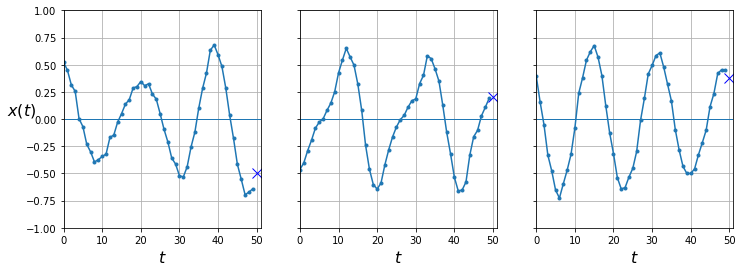

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

E' utile, come fatto per il perceptron, definire alcuni modelli baseline per confrontare le performance ottenute.

Il primo modello restituisce il valore della serie al tempo $t-1$.

In [12]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020709343

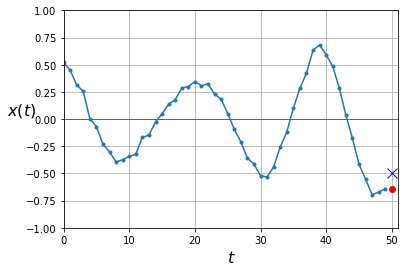

In [13]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Il secondo modello e' una rete fully connected.

In [14]:
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0823 - val_loss: 0.0449
Epoch 2/20
219/219 [==============================] - 0s 602us/step - loss: 0.0353 - val_loss: 0.0273
Epoch 3/20
219/219 [==============================] - 0s 632us/step - loss: 0.0227 - val_loss: 0.0189
Epoch 4/20
219/219 [==============================] - 0s 578us/step - loss: 0.0161 - val_loss: 0.0141
Epoch 5/20
219/219 [==============================] - 0s 642us/step - loss: 0.0123 - val_loss: 0.0113
Epoch 6/20
219/219 [==============================] - 0s 576us/step - loss: 0.0100 - val_loss: 0.0095
Epoch 7/20
219/219 [==============================] - 0s 600us/step - loss: 0.0086 - val_loss: 0.0084
Epoch 8/20
219/219 [==============================] - 0s 650us/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/20
219/219 [==============================] - 0s 572us/step - loss: 0.0071 - val_loss: 0.0072
Epoch 10/20
219/219 [==============================] - 0s 646us/step - loss: 0.0066 

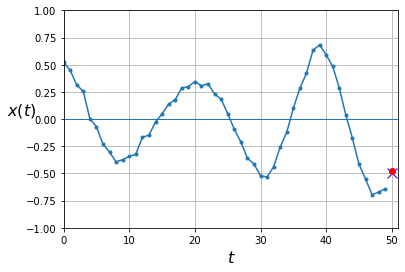

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Infine definiamo un RNN con una sola unita' ricorrente e funzione di attivazione $tanh$ - default.

In [16]:
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0842 - val_loss: 0.0462
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0412 - val_loss: 0.0374
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0347 - val_loss: 0.0324
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0306 - val_loss: 0.0290
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0277 - val_loss: 0.0265
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0255 - val_loss: 0.0245
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0238 - val_loss: 0.0230
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0224 - val_loss: 0.0217
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0212 - val_loss: 0.0206
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0203 - val_loss: 0.0197

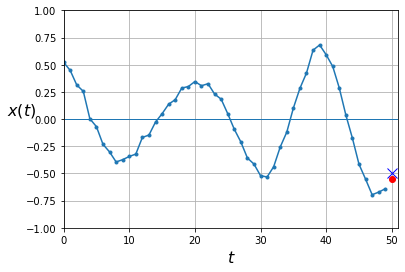

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Infine inseriamo piu' hidden layer costituiti da piu' unita' ricorrenti

In [18]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0481 - val_loss: 0.0129
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0120 - val_loss: 0.0103
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 9/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0047 - val_loss: 0.0068
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0046 - val_lo

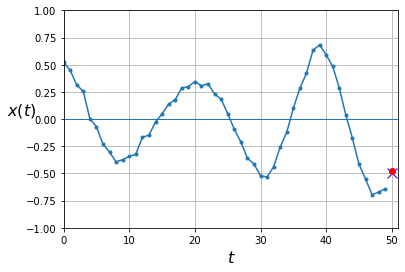

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Dal momento che per l'ultimo layer non ci interessa l'ouput $h_{out}$, possiamo utilizzare un livello denso con una singola unita' di output.

In [20]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0375 - val_loss: 0.0147
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0114 - val_loss: 0.0091
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0038 - val_lo

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Per predirre i prossimi $k$ valori futuri come primo approccio posso utilizzare le predizioni eseguite fino al passo $t+1$ come input del mio modello. In sostanza, predico sulle predizioni. 

Ho un problema di accumulazione dell'errore di predizione.

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [ ]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

In [ ]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Definiamo un RNN che restituisce un vettore di 10 elementi

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

Possiamo addestrare il modello in modo che predica i prossimi $k$ valori ad ogni time step, anziche' all'ultimo step $t=50$. Sfrutto gli aggiornamenti del gradiente provenienti da tutti gli output $y_{t}$. Il modello risultante e' nella categoria many-to-many.

Dobbiamo modificare il vettore delle etichette = sequenza di vettori

In [29]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [28]:
Y[1].shape

(50, 10)

Ogni layer deve restituire sempre una sequenza => **return_sequence=True**. Inoltre, possiamo utilizzare il layer **TimeDistributed** per applicare il layer ad ongi time step della sequenza di input.

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

La loss function si calcola sull'ouput dell'ultimo time step.

In [ ]:
@tf.autograph.experimental.do_not_convert
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
model.compile(loss="mse", optimizer='sgd', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)

## Long memory cells
Usando la cella di memoria base lo stato dei primi elementi della sequenza puo' non influire sulla predizione al tempo $t$. Per alleviare questo fenomeno sono state proposte diversi cell con memoria a lungo termine - long-term memory.

### Long short-term memory - LSTM

![](lstm_cell.png)

dove informalmente $\mathbf{h}_t$ rappresenta la memoria a breve termine, mentre $\mathbf{c}_t$ rappresenta la memoria a lungo termine.

![](lstm_equation.png)

### Gated Recurrent Unit - GRU

![](gru.png)

I vettori $h$ e $c$ vengono uniti. C'e' un solo gate controller $z$ che controlla forget e input gate. C'e' un nuovo gae controller che agisce sull'input del main gate $g$ e sceglie quale parte dello stato precedente utilizzare. 

![](gru_equation.png)

In Keras vengono rsi disponibili i due layers: **LSTM** e **GRU**

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="sgd", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
